100%|██████████| 3990/3990 [00:02<00:00, 1620.64it/s]


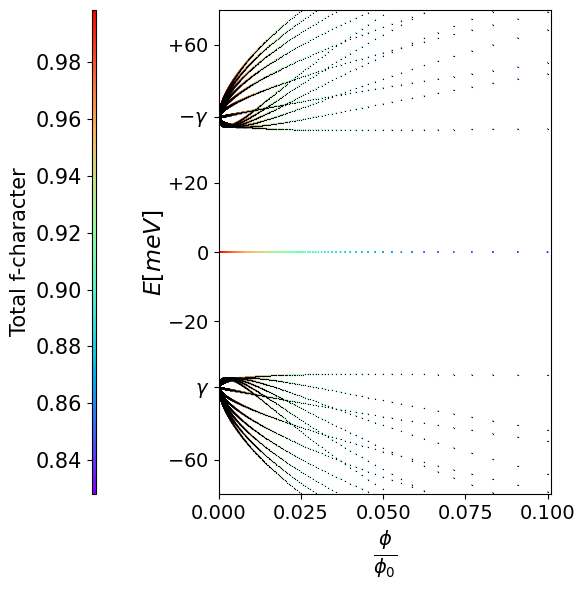

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from scipy import linalg
import matplotlib.pyplot as plt

import ctypes
from tqdm import tqdm
import warnings
import datetime
import time
import dataclasses
import os.path
import math
import matplotlib.cm as cm




##defining constants first based on bernvig_Song # w0/w1=0.7

theta = np.deg2rad(1.05) #default 1.05
pi = np.pi
j_mx = int(3)


a_lat = 2.46 #Angs
Lm = a_lat/(2*np.sin(theta/2)) #Angs
L1 = np.array([Lm*np.sqrt(3)/2,Lm/2])
L2 = np.array([0,Lm])
omega_m = np.sqrt(3)*(Lm**2)/2 #Angs^2
q_2 = (4*pi/(3*Lm))*np.array([np.sqrt(3)/2,1/2])
lambd = 0.3792*Lm #default 0.3792*Lm
gamma = -39.11 #mev
v_star_prime = 1624 #mev.Angs
v_star = -4483 #meV.Angs
U1 = 0#51.72 #mev default
J =  0#18.27 #mev default
M = 0 #mev default



def twoMBZ(N):
    
    #pathI:KM->Gamma
    kxI = np.linspace(0,q_2[0],N)
    kyI = (1/np.sqrt(3))*kxI
    
    kxI = np.flip(kxI)
    kyI = np.flip(kyI)
    
    
    #pathII:Gamma+ -> Mm
    kxII = np.linspace(0,q_2[0],N)[1:]
    kyII = np.zeros(len(kxII))
        
    KX = np.concatenate((kxI,kxII),axis=None)
    KY = np.concatenate((kyI,kyII),axis=None)
    
    
    return KX,KY, len(kxI)-1


def two_hermite(x,y,n):
    H_n = 0
    n = int(n)
    for k in range(math.floor(n/2)+1):
        H_n = H_n + ((x**(n-2*k))*(y**k))/((math.factorial(n-2*k))*(math.factorial(k)))
    H_n = H_n*math.factorial(n)
    return H_n

def four_hermite(y_br,tau,n):
    H_n = 0
    n = int(n)
    for k in range(n+1):
        H_n = H_n + math.factorial(n)*(tau**k)*math.factorial(n)*(two_hermite(0,y_br,n-k)*two_hermite(0,y_br,n-k))/(math.factorial(n-k)*math.factorial(n-k)*math.factorial(k))
    return H_n        

def F_m(q, n, x0):
    
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    x0 = x0*L1[0] #angs
    F = ((np.sqrt((lb**2)/(lb**2 + lambd**2)))/((pi**0.25)*(np.sqrt((2**(float(n)))*(math.factorial(int(n)))))))*(np.exp(-1*(x0**2)/(2*(lb**2 + lambd**2))))*(two_hermite(-1*2*x0*lb/(lb**2 + lambd**2), 2*(lambd**2)/(lb**2 + lambd**2) - 1, n))                                           
    
    return F

def Io_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs

    I_O = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r- j*q)*(k2/2 - k1)) + (1j*pi*(r- j*q)*(r- j*q -1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_O[m,r] = np.sqrt(L1[0]/lb)*u
    
    return I_O

def Iy_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    
    I_y = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + (k2 + r/q - j)*np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_y[m,r] = 2*pi*np.sqrt(L1[0]/lb)*u/Lm
    
    return I_y

def Ix_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    
    I_x = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(1,m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(np.sqrt(m)*F_m(q, m-1, (-j+k2)*q + r) - np.sqrt(m+1)*F_m(q, m+1, (-j+k2)*q + r))
            I_x[m,r] = u*1j*(np.sqrt(L1[0]/lb)/(lb*np.sqrt(2)))
    
    for r in range(q):
        u = 0
        for j in range(-j_mx,j_mx+1):
            u = u + np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(-1*np.sqrt(1)*F_m(q, 1, (-j+k2)*q + r))
        I_x[0,r] = u*1j*(np.sqrt(L1[0]/lb)/(lb*np.sqrt(2)))
        
    return I_x

def gen_pqlist(min_q = 5, max_q = 80):
    plist = np.array([])
    qlist = np.array([])
    for q in range(min_q, max_q + 1):
        plist = np.append(plist, 1)
        qlist = np.append(qlist, q)
    pqlist = plist / qlist
    s_ind = np.argsort(pqlist)
    plist = plist[s_ind]
    qlist = qlist[s_ind]
    pqlist = pqlist[s_ind]
    return plist, qlist, pqlist


def omega0_builder(m_max,flux):
    m_max = int(m_max)
    
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
    
    
    
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
    for m in range(m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*four_hermite(y_br,tau,m)/((2**m)*math.factorial(m)))
    return zeta_2  

def assym_SVD1(m,y_br):
    
    m = int(m)
    if (m%2==0):
        return y_br**m
    else:
        return 0

def assym_SVD2(m,y_br,tau):
    
    sum_ = 0
    for k in range(1,m):
        if (m-k)%2==0:
            sum_ = sum_ + np.exp(m*np.log(m/(m-k)) + k*np.log((m-k)/k))*((tau/2)**k)*(y_br**(m-k))
        else:
            sum_ = sum_
    
    return sum_
    
def assymptotic_SVD(m_max,flux):
    
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
    
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
    
    zeta_2[0] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa)))
    for m in range(1,m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*((tau/2)**m + assym_SVD1(m,y_br) + assym_SVD2(m,y_br,tau)))
    
    return zeta_2

def get_weights_3and5(zeta,flux):
    
    lb_inv = (2*pi*flux/omega_m)**(1/2)
    f_char3 = (np.abs(np.sqrt(2)*v_star*lb_inv)**2)/(np.abs(-1j*zeta[0]*gamma)**2 + np.abs(np.sqrt(2)*v_star*lb_inv)**2)
    f_char5 = (np.abs(-2*1j*zeta[0]*gamma*v_star*lb_inv)**2 + np.abs(2*np.sqrt(2)*zeta[1]*v_star*v_star_prime*lb_inv*lb_inv)**2)/(np.abs(zeta[0]*zeta[1]*(2*(v_star_prime**2)*(lb_inv**2)-gamma**2))**2 + np.abs(-2*1j*zeta[0]*gamma*v_star*lb_inv)**2 + np.abs(2*np.sqrt(2)*zeta[1]*v_star*v_star_prime*lb_inv*lb_inv)**2)
    
    return f_char3, f_char5

def get_weights_6(zeta,m_max,flux):
    
    lb_inv = (2*pi*flux/omega_m)**(1/2)
    m_max = int(m_max)
    f_char6 = np.zeros((2,m_max),dtype=np.float64)
    for m in range(m_max):
        k=m+2
        f_char6[0,m] = (np.abs(np.sqrt(2*k*k-2)*v_star*lb_inv)**2)/(np.abs(np.sqrt(2*k*k-2*k)*zeta[k-1]*v_star_prime*lb_inv)**2 + np.abs(1j*np.sqrt(k+1)*gamma*zeta[k-1])**2 + np.abs(np.sqrt(2*k*k-2)*v_star*lb_inv)**2)
        f_char6[1,m] = (np.abs(np.sqrt(2*k*k-2)*v_star*lb_inv)**2)/(np.abs(np.sqrt(2*k*k+2*k)*zeta[k]*v_star_prime*lb_inv)**2 + np.abs(-1j*np.sqrt(k-1)*gamma*zeta[k])**2 + np.abs(np.sqrt(2*k*k-2)*v_star*lb_inv)**2)
        
    return f_char6    

def get_singular_val(flux,m_max):
    m_max = int(m_max)
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+5,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num
    return zeta


def hamiltonian_lowB_analytical_eta_minus1(flux,zeta,m_max,scaling):
    
    m_max = int(m_max)
   
    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*m_max +5+ 3+1, 6*m_max+5 + 3+1), dtype = np.complex128)

    h_low[0,0] = 0
    
    h_low[1,2] = -1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = scaling*gamma*zeta[0]
    
    h_low[4,6] = -1j*2*v_star*lb_inv
    h_low[4,7] = scaling*gamma*zeta[1]
    h_low[4,8] = scaling*1j*np.sqrt(2)*v_star_prime*lb_inv*zeta[0]
    h_low[5,7] = -scaling*1j*np.sqrt(2)*v_star_prime*lb_inv*zeta[1]
    h_low[5,8] = scaling*gamma*zeta[0]
        
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = scaling*zeta[k]*gamma
        h_low[6*m+9,6*m+9+5] = 1j*scaling*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k-1]
        h_low[6*m+9+1,6*m+9+3] = 1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9+1,6*m+9+4] = -1j*scaling*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k]
        h_low[6*m+9+1,6*m+9+5] = scaling*zeta[k-1]*gamma
    
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)
    eigvals, eigvecs = linalg.eigh(h_low)
    eigvecs = np.transpose(eigvecs)
    
    return eigvals


def f_tot(zeta,m_max,flux,q):
    f_char6 = get_weights_6(zeta,m_max,flux)
    f_char3, f_char5 = get_weights_3and5(zeta,flux)
    f_tot = f_char3 + f_char5
    for m in range(int(m_max)):
        f_tot = f_tot + f_char6[0,m] + f_char6[1,m]
    f_tot = f_tot + (2*q-(2*m_max+3)) 
    f_tot = f_tot/(2*q)
    return f_tot
    
    
def get_spectrum(scale):
    
    plist, qlist, flux = gen_pqlist(10,4000)
    m_max = 5*np.ones(len(flux),dtype=int)
    zeta0 = get_singular_val(flux[0],m_max[0])
    eigval = hamiltonian_lowB_analytical_eta_minus1(flux[0],zeta0,m_max[0],scale)
    fchar = f_tot(zeta0,m_max[0],flux[0],qlist[0])*np.ones(len(eigval))
    
    pq_points_lowb = flux[0]*np.ones(len(eigval))

    for q in tqdm(range(1,len(flux))):
        zeta = get_singular_val(flux[q],m_max[q])
        eigs_upd = hamiltonian_lowB_analytical_eta_minus1(flux[q],zeta,m_max[q],scale)
        f_char_tot = f_tot(zeta,m_max[q],flux[q],qlist[q])
        
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
        fchar = np.concatenate((fchar,f_char_tot*np.ones(len(eigs_upd))),axis=None)
    
    e_point_lowb = eigval
    f_point_lowb = fchar
  
    return pq_points_lowb , e_point_lowb , f_point_lowb

if __name__ == '__main__':
    pq_points_lowb , e_point_lowb , f_point_lowb = get_spectrum(1)
    pq_points_lowb_NB = np.array([])
    pq_points_lowb_RB = np.array([])
    e_point_lowb_NB = np.array([])
    e_point_lowb_RB = np.array([])
    f_char_lowb_NB = np.array([])

    for idx in range(len(pq_points_lowb)):
        if e_point_lowb[idx]>-10 and e_point_lowb[idx]<10:
            pq_points_lowb_NB = np.concatenate((pq_points_lowb_NB,pq_points_lowb[idx]),axis=None)
            e_point_lowb_NB = np.concatenate((e_point_lowb_NB,e_point_lowb[idx]),axis=None)
            f_char_lowb_NB = np.concatenate((f_char_lowb_NB,f_point_lowb[idx]),axis=None)
        else:
            pq_points_lowb_RB = np.concatenate((pq_points_lowb_RB,pq_points_lowb[idx]),axis=None)
            e_point_lowb_RB = np.concatenate((e_point_lowb_RB,e_point_lowb[idx]),axis=None)
            
    plt.scatter(pq_points_lowb, e_point_lowb, c= f_point_lowb, cmap = "rainbow", marker='o', lw=0,s=0.8)
    cbar = plt.colorbar(orientation="vertical",location='left',pad=0.23, shrink=1, aspect=120)
    cbar.set_label(label="Total f-character",size=15)
    cbar.ax.tick_params(labelsize=15)

    plt.scatter(pq_points_lowb_RB, e_point_lowb_RB, color='black',marker='o', lw=0,s=0.8)
    plt.yticks([gamma,-gamma,-20,+20,-60,+60,0],[r'$\gamma$',r'$-\gamma$',r'$-20$',r'$+20$',r'$-60$',r'$+60$',r'$0$'])

        
    
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=14)
    plt.tick_params(axis='x', which='both', labelsize=14)

    plt.xlabel(r'$\frac{\phi}{\phi_0}$',fontsize=20)
    plt.ylabel(r'$E[meV]$',labelpad=1,fontsize=17)
    label = []
    label =np.array(label)
    for k in range(-65,66):
        if k%20==0:
            if k!=40:
                if k!=-40:
                    label = np.append(label,k)
    label = np.append(label,gamma)
    label = np.append(label,-gamma)   
    plt.yticks(label)
    plt.xlim(0,0.101)
    plt.ylim(-70,70)
    plt.gcf().set_size_inches((6,6))    
    plt.tight_layout()

    plt.savefig('Non_interacting_FlatBand.jpg',bbox_inches='tight', dpi=1000)    




0.03120427463821313


100%|██████████| 690/690 [29:07<00:00,  2.53s/it] 


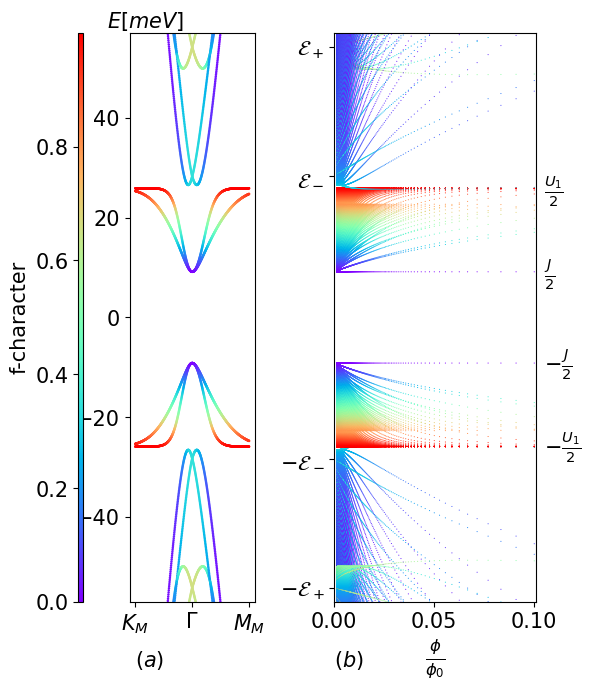

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from scipy import linalg
import matplotlib.pyplot as plt

import ctypes
from tqdm import tqdm
import warnings
import datetime
import time
import dataclasses
import os.path
import math
import matplotlib.cm as cm




##defining constants first based on bernvig_Song # w0/w1=0.7

theta = np.deg2rad(1.05) #default 1.05
pi = np.pi
j_mx = int(3)


a_lat = 2.46 #Angs
Lm = a_lat/(2*np.sin(theta/2)) #Angs
L1 = np.array([Lm*np.sqrt(3)/2,Lm/2])
L2 = np.array([0,Lm])
omega_m = np.sqrt(3)*(Lm**2)/2 #Angs^2
q_2 = (4*pi/(3*Lm))*np.array([np.sqrt(3)/2,1/2])
lambd = 0.3792*Lm #default 0.3792*Lm
gamma = -39.11 #mev
v_star_prime = 1624 #mev.Angs
v_star = -4483 #meV.Angs
U1 = 51.72 #mev default
J =  18.27 #mev default
M = 0 #mev default


def twoMBZ(N):
    
    #pathI:KM->Gamma
    kxI = np.linspace(0,q_2[0],N)
    kyI = (1/np.sqrt(3))*kxI
    
    kxI = np.flip(kxI)
    kyI = np.flip(kyI)
    
    
    #pathII:Gamma+ -> Mm
    kxII = np.linspace(0,q_2[0],N)[1:]
    kyII = np.zeros(len(kxII))
        
    KX = np.concatenate((kxI,kxII),axis=None)
    KY = np.concatenate((kyI,kyII),axis=None)
    
    
    return KX,KY, len(kxI)-1


def two_hermite(x,y,n):
    H_n = 0
    n = int(n)
    for k in range(math.floor(n/2)+1):
        H_n = H_n + ((x**(n-2*k))*(y**k))/((math.factorial(n-2*k))*(math.factorial(k)))
    H_n = H_n*math.factorial(n)
    return H_n

def four_hermite(y_br,tau,n):
    H_n = 0
    n = int(n)
    for k in range(n+1):
        H_n = H_n + math.factorial(n)*(tau**k)*math.factorial(n)*(two_hermite(0,y_br,n-k)*two_hermite(0,y_br,n-k))/(math.factorial(n-k)*math.factorial(n-k)*math.factorial(k))
    return H_n        

def F_m(q, n, x0):
    
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    x0 = x0*L1[0] #angs
    F = ((np.sqrt((lb**2)/(lb**2 + lambd**2)))/((pi**0.25)*(np.sqrt((2**(float(n)))*(math.factorial(int(n)))))))*(np.exp(-1*(x0**2)/(2*(lb**2 + lambd**2))))*(two_hermite(-1*2*x0*lb/(lb**2 + lambd**2), 2*(lambd**2)/(lb**2 + lambd**2) - 1, n))                                           
    
    return F

def Io_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs

    I_O = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r- j*q)*(k2/2 - k1)) + (1j*pi*(r- j*q)*(r- j*q -1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_O[m,r] = np.sqrt(L1[0]/lb)*u
    
    return I_O

def Iy_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    
    I_y = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + (k2 + r/q - j)*np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_y[m,r] = 2*pi*np.sqrt(L1[0]/lb)*u/Lm
    
    return I_y

def Ix_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    
    I_x = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(1,m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(np.sqrt(m)*F_m(q, m-1, (-j+k2)*q + r) - np.sqrt(m+1)*F_m(q, m+1, (-j+k2)*q + r))
            I_x[m,r] = u*1j*(np.sqrt(L1[0]/lb)/(lb*np.sqrt(2)))
    
    for r in range(q):
        u = 0
        for j in range(-j_mx,j_mx+1):
            u = u + np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(-1*np.sqrt(1)*F_m(q, 1, (-j+k2)*q + r))
        I_x[0,r] = u*1j*(np.sqrt(L1[0]/lb)/(lb*np.sqrt(2)))
        
    return I_x

def gen_pqlist(min_q = 5, max_q = 80):
    plist = np.array([])
    qlist = np.array([])
    for q in range(min_q, max_q + 1):
        plist = np.append(plist, 1)
        qlist = np.append(qlist, q)
    pqlist = plist / qlist
    s_ind = np.argsort(pqlist)
    plist = plist[s_ind]
    qlist = qlist[s_ind]
    pqlist = pqlist[s_ind]
    return plist, qlist, pqlist


def omega0_builder(m_max,flux):
    m_max = int(m_max)
    
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
    
    #print(kppa,tau,y_br,f,"at flux =",flux)
    
    
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
    for m in range(m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*four_hermite(y_br,tau,m)/((2**m)*math.factorial(m)))
    #print (zeta_2[0],flux)
    
    #print("analytical", zeta_2,flux)    
    return zeta_2  

def assym_SVD1(m,y_br):
    
    m = int(m)
    if (m%2==0):
        return y_br**m
    else:
        return 0

def assym_SVD2(m,y_br,tau):
    
    sum_ = 0
    for k in range(1,m):
        if (m-k)%2==0:
            sum_ = sum_ + np.exp(m*np.log(m/(m-k)) + k*np.log((m-k)/k))*((tau/2)**k)*(y_br**(m-k))
        else:
            sum_ = sum_
    
    return sum_
    
def assymptotic_SVD(m_max,flux):
    
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
    
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
    
    zeta_2[0] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa)))
    for m in range(1,m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*((tau/2)**m + assym_SVD1(m,y_br) + assym_SVD2(m,y_br,tau)))
    
    return zeta_2


def hamiltonian_lowB_analytical_eta_minus1(flux,m_max):
    
    m_max = int(m_max)
        
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux) #although we use q>145 anyway so its numerical 
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num
        
    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*(m_max) +5+ 3+1, 6*(m_max)+5 + 3+1), dtype = np.complex128)

    h_low[0,0] = J/4
    
    h_low[1,2] = 1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
    h_low[2,2] = J/4
    h_low[3,3] = U1/4
    

    h_low[6,6] = +J/4
    h_low[7,7] = +U1/4 
    h_low[8,8] = +U1/4 
    h_low[4,7] = gamma*zeta[0]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,6] = 1j*2*v_star*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,8] = gamma*zeta[1]
    
    
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k-1]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k]*lb_inv
        h_low[6*m+9+1,6*m+9+3] = 1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9+1,6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k-1]
        h_low[6*m+9+1,6*m+9+5] = gamma*zeta[k]
        h_low[6*m+9+2,6*m+9+2] = J/4
        h_low[6*m+9+3,6*m+9+3] = J/4
        h_low[6*m+9+4,6*m+9+4] = U1/4
        h_low[6*m+9+5,6*m+9+5] = U1/4

    
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)

    eigvals, eigvecs = linalg.eigh(h_low)
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][3])**2 + np.abs(eigvecs[t][7])**2 + np.abs(eigvecs[t][8])**2
        for m in range(m_max):
            f_char[t] = f_char[t] + np.abs(eigvecs[t][6*m+13])**2 + np.abs(eigvecs[t][6*m+14])**2
    
    return eigvals, f_char

def hamiltonian_lowB_analytical_eta_1(flux,m_max):
    
    m_max = int(m_max)
    
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux)
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num

    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*m_max +5+ 3+1, 6*m_max+5 + 3+1), dtype = np.complex128)
    
    #1x1
    h_low[0,0] = -J/4
    
    #3x3
    h_low[2,2] = - J/4
    h_low[3,3] = -U1/4
    h_low[1,2] = -1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
    
    #5x5
    h_low[6,6] = - J/4
    h_low[7,7] = -U1/4 
    h_low[8,8] = -U1/4 
    h_low[4,6] = -1j*2*v_star*lb_inv
    h_low[4,7] = gamma*zeta[1]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,8] = gamma*zeta[0]
    
    #6x6
    for m in range(m_max):
        k = m+2
        h_low[6*m+11,6*m+11] =  - J/4
        h_low[6*m+12,6*m+12] = - J/4
        h_low[6*m+13,6*m+13] = -U1/4 
        h_low[6*m+14,6*m+14] = -U1/4 
        
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k-1]*lb_inv
        
        h_low[6*m+9+1, 6*m+9+3] = 1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9+1, 6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k]
        h_low[6*m+9+1, 6*m+9+5] = gamma*zeta[k-1]

    
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)
    #print(v_star/lb,"cc_escale in mev","v_star in mev/A, lb in ang",lb,v_star) 
    eigvals, eigvecs = linalg.eigh(h_low)
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][3])**2 + np.abs(eigvecs[t][7])**2 + np.abs(eigvecs[t][8])**2
        for m in range(m_max):
            f_char[t] = f_char[t] + np.abs(eigvecs[t][6*m+13])**2 + np.abs(eigvecs[t][6*m+14])**2
    
    return eigvals, f_char

def zero_fieldHam(kx,ky):
    
    hK = np.zeros((12,12), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
    
    hK[0,2] = v_star*k
    hK[0,4] = ep_fac*gamma
    hK[0,5] = ep_fac*v_star_prime*k_br
    hK[1,3] = v_star*k_br
    hK[1,4] = ep_fac*v_star_prime*k
    hK[1,5] = ep_fac*gamma
    hK[2,2] = -J/4
    hK[3,3] = -J/4
    hK[4,4] = -U1/4
    hK[5,5] = -U1/4
    
    hK[0+6,2+6] = -v_star*k_br
    hK[0+6,4+6] = ep_fac*gamma
    hK[0+6,5+6] = -ep_fac*v_star_prime*k
    hK[1+6,3+6] = -v_star*k
    hK[1+6,4+6] = -ep_fac*v_star_prime*k_br
    hK[1+6,5+6] = ep_fac*gamma
    hK[2+6,2+6] = J/4
    hK[3+6,3+6] = J/4
    hK[4+6,4+6] = U1/4
    hK[5+6,5+6] = U1/4
    
    hK = hK + np.transpose(np.conj(hK))
    
    eigvals, eigvecs = linalg.eigh(hK)
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][4])**2 + np.abs(eigvecs[t][5])**2 + np.abs(eigvecs[t][10])**2 + np.abs(eigvecs[t][11])**2
    
    return eigvals, f_char


def get_spectrum():
        
    q_max_numr = 700
    q_min_numr = 10
    flux = []
    flux=np.array(flux)
    m_max = []
    m_max = np.array(m_max)
    q_points = np.linspace(q_max_numr,q_min_numr, num=q_max_numr-q_min_numr+1,dtype=int)
    
    for q in tqdm(range(len(q_points))):
        fl_pt = 1/(q_points[q])
        m_pt = np.ceil((q_points[q]-3)/2)
        flux = np.append(flux,fl_pt)
        m_max = np.append(m_max,m_pt)

    eigval,fchar = hamiltonian_lowB_analytical_eta_minus1(flux[0],m_max[0])
    
    eigval2,fchar2 = hamiltonian_lowB_analytical_eta_1(flux[0],m_max[0])

    pq_points_lowb = flux[0]*np.ones(len(eigval))

    for q in tqdm(range(1,len(flux))):
        eigs_upd, fchar_upd = hamiltonian_lowB_analytical_eta_minus1(flux[q],m_max[q])
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
        fchar = np.concatenate((fchar,fchar_upd),axis=None)
        
        eigs_upd2, fchar_upd2 = hamiltonian_lowB_analytical_eta_1(flux[q],m_max[q])
        eigval2 = np.concatenate((eigval2,eigs_upd2), axis=None)
        fchar2 = np.concatenate((fchar2,fchar_upd2),axis=None)

    e_point_lowb = eigval
    f_point_lowb = fchar
    
    e_point_lowb2 = eigval2
    f_point_lowb2 = fchar2

    for q in range(len(q_points)):
        qpt0 = int(q_points[q])
        e_point_lowb = np.concatenate((e_point_lowb,(U1/2)*np.ones(int(2*qpt0-2*m_max[q]-3))), axis=None)
        f_point_lowb = np.concatenate((f_point_lowb,np.ones(int(2*qpt0-2*m_max[q]-3))),axis=None)
        
        e_point_lowb2 = np.concatenate((e_point_lowb2,(-U1/2)*np.ones(int(2*qpt0-2*m_max[q]-3))), axis=None)
        f_point_lowb2 = np.concatenate((f_point_lowb2, np.ones(int(2*qpt0-2*m_max[q]-3))),axis=None)

        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(int(2*qpt0-2*m_max[q]-3))), axis=None)

    return pq_points_lowb , e_point_lowb , f_point_lowb, e_point_lowb2 , f_point_lowb2


def getzerofieldspectrum():
    
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),12), dtype = np.float64)
    fchar_table = np.zeros((len(KX),12), dtype = np.float64)
    

    for i in range(len(KX)):
        eigval_table[i], fchar_table[i]  = zero_fieldHam(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
    
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
    f_point_lowb = fchar_table.flatten()
    
    return k_points_lowb , e_point_lowb , f_point_lowb, Km, Mm, Gm
    


if __name__ == '__main__':
        
    k_points0 , e_point0 , f_point0, Km, Mm, Gm = getzerofieldspectrum()
    
    plt.subplot(1, 2, 1)
    plt.scatter(k_points0, e_point0, c= f_point0, cmap = "rainbow", marker='o', lw=1,s=0.6)
    cbar = plt.colorbar(orientation="vertical",location='left',pad=0.23, shrink=1, aspect=120)
    cbar.set_label(label="f-character",size=15)
    cbar.ax.tick_params(labelsize=15)
    plt.xticks([Km, Gm, Mm],["$K_{M}$", "$\Gamma$","$M_{M}$"])
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.text(-150, 58, r'$E[meV]$', fontsize = 15)
    plt.text(0,-70,r'$(a)$',fontsize=15)



    plt.ylim(-57,57)
    plt.gcf().set_size_inches((8,13)) 
    
    
    pq_points_lowb , e_point_lowbK , colorsK, e_point_lowbKpm , colorsKpm = get_spectrum()
    

    
    plt.subplot(1, 2, 2)
    plt.scatter(pq_points_lowb, e_point_lowbK, c= colorsK, cmap = "rainbow", marker='o', lw=0,s=0.6)
    plt.scatter(pq_points_lowb, e_point_lowbKpm, c= colorsKpm, cmap = "rainbow", marker='o', lw=0,s=0.6)

    plt.xlabel(r'$\frac{\phi}{\phi_0}$',fontsize=17)
    plt.xlim(0,0.101) 
    plt.ylim(-57,57)
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.text(0.105,U1/2-2,r'$\frac{U_1}{2}$',fontsize = 15)
    plt.text(0.105,J/2-2,r'$\frac{J}{2}$',fontsize = 15)
    plt.text(0.105,-U1/2-1.7,r'$-\frac{U_1}{2}$',fontsize = 15)
    plt.text(0.105,-J/2-1.7,r'$-\frac{J}{2}$',fontsize = 15)
    plt.text(0,-70,r'$(b)$',fontsize=15)
    
    plt.yticks([U1/4 + np.sqrt((U1**2)/16 + gamma**2),-U1/4 + np.sqrt((U1**2)/16 + gamma**2),U1/4 - np.sqrt((U1**2)/16 + gamma**2),-U1/4 - np.sqrt((U1**2)/16 + gamma**2)], [r'$\mathcal{E}_+$',r'$\mathcal{E}_-$', r'$-\mathcal{E}_-$', r'$-\mathcal{E}_+$'])
    plt.gcf().set_size_inches((6,7))    
    plt.tight_layout()

    plt.savefig('CNP_flatband.jpg',bbox_inches='tight', dpi=1200)    

    

100%|██████████| 689/689 [06:00<00:00,  1.91it/s] 


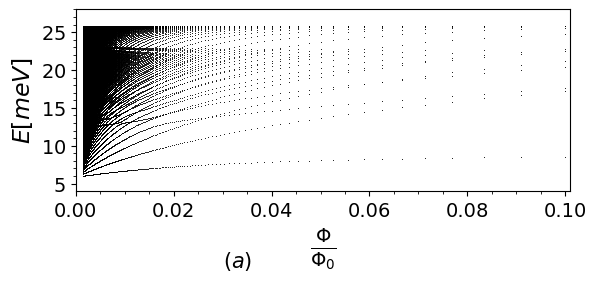

In [18]:
import numpy as np
from tqdm import tqdm
from scipy import linalg
import matplotlib.pyplot as plt
import ctypes
from tqdm import tqdm
import warnings
import datetime
import time
import dataclasses
import os.path
import math
import matplotlib.cm as cm


##defining constants first based on bernvig_Song # w0/w1=0.7

theta = np.deg2rad(1.05) #default 1.05
pi = np.pi
j_mx = int(3)
a_lat = 2.46 #Angs
Lm = a_lat/(2*np.sin(theta/2)) #Angs
L1 = np.array([Lm*np.sqrt(3)/2,Lm/2])
L2 = np.array([0,Lm])
omega_m = np.sqrt(3)*(Lm**2)/2 #Angs^2
q_2 = (4*pi/(3*Lm))*np.array([np.sqrt(3)/2,1/2])
lambd = 0.3792*Lm #default 0.3792*Lm
gamma = -39.11 #mev
v_star_prime = 1624 #mev.Angs
v_star = -4483 #meV.Angs
U1 = 51.72 #mev default
J =  18.27 #mev default
M = 3.248 #mev default
W1 = 44.05
W3 = 49.33
U2 = 2.656

def two_hermite(x,y,n):
    H_n = 0
    n = int(n)
    for k in range(math.floor(n/2)+1):
        H_n = H_n + ((x**(n-2*k))*(y**k))/((math.factorial(n-2*k))*(math.factorial(k)))
    H_n = H_n*math.factorial(n)
    return H_n

def four_hermite(y_br,tau,n):
    H_n = 0
    n = int(n)
    for k in range(n+1):
        H_n = H_n + math.factorial(n)*(tau**k)*math.factorial(n)*(two_hermite(0,y_br,n-k)*two_hermite(0,y_br,n-k))/(math.factorial(n-k)*math.factorial(n-k)*math.factorial(k))
    return H_n        

def F_m(q, n, x0):
    
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    x0 = x0*L1[0] #angs
    F = ((np.sqrt((lb**2)/(lb**2 + lambd**2)))/((pi**0.25)*(np.sqrt((2**(float(n)))*(math.factorial(int(n)))))))*(np.exp(-1*(x0**2)/(2*(lb**2 + lambd**2))))*(two_hermite(-1*2*x0*lb/(lb**2 + lambd**2), 2*(lambd**2)/(lb**2 + lambd**2) - 1, n))                                           
    
    return F

def Io_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs

    I_O = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r- j*q)*(k2/2 - k1)) + (1j*pi*(r- j*q)*(r- j*q -1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_O[m,r] = np.sqrt(L1[0]/lb)*u
    
    return I_O

def Iy_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    
    I_y = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + (k2 + r/q - j)*np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_y[m,r] = 2*pi*np.sqrt(L1[0]/lb)*u/Lm
    
    return I_y

def Ix_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    
    I_x = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(1,m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(np.sqrt(m)*F_m(q, m-1, (-j+k2)*q + r) - np.sqrt(m+1)*F_m(q, m+1, (-j+k2)*q + r))
            I_x[m,r] = u*1j*(np.sqrt(L1[0]/lb)/(lb*np.sqrt(2)))
    
    for r in range(q):
        u = 0
        for j in range(-j_mx,j_mx+1):
            u = u + np.exp((2*pi*1j*(r-j*q)*(k2/2 - k1)) + (1j*pi*(r-j*q)*(r-j*q-1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(-1*np.sqrt(1)*F_m(q, 1, (-j+k2)*q + r))
        I_x[0,r] = u*1j*(np.sqrt(L1[0]/lb)/(lb*np.sqrt(2)))
        
    return I_x

def gen_pqlist(min_q = 5, max_q = 80):
    plist = np.array([])
    qlist = np.array([])
    for q in range(min_q, max_q + 1):
        plist = np.append(plist, 1)
        qlist = np.append(qlist, q)
    pqlist = plist / qlist
    s_ind = np.argsort(pqlist)
    plist = plist[s_ind]
    qlist = qlist[s_ind]
    pqlist = pqlist[s_ind]
    return plist, qlist, pqlist



def omega0_builder(m_max,flux):
    m_max = int(m_max)
    
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
    
    
    
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
    for m in range(m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*four_hermite(y_br,tau,m)/((2**m)*math.factorial(m)))
        
    return zeta_2  

def assym_SVD1(m,y_br):
    
    m = int(m)
    if (m%2==0):
        return y_br**m
    else:
        return 0

def assym_SVD2(m,y_br,tau):
    
    sum_ = 0
    for k in range(1,m):
        if (m-k)%2==0:
            sum_ = sum_ + np.exp(m*np.log(m/(m-k)) + k*np.log((m-k)/k))*((tau/2)**k)*(y_br**(m-k))
        else:
            sum_ = sum_
    
    return sum_
    
def assymptotic_SVD(m_max,flux):
    
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
    
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
    
    zeta_2[0] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa)))
    for m in range(1,m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*((tau/2)**m + assym_SVD1(m,y_br) + assym_SVD2(m,y_br,tau)))
    
    return zeta_2
def hamiltonian_lowB_analytical_eta_minus1_correct(flux,m_max):
    
    m_max = int(m_max)
        
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux) #although we use q>145 anyway so its numerical 
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num
        
    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*(m_max) +5+ 3+1, 6*(m_max)+5 + 3+1), dtype = np.complex128)

    h_low[0,0] = J/4
    
    h_low[1,2] = 1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
    h_low[2,2] = J/4
    h_low[3,3] = U1/4
    

    h_low[6,6] = +J/4
    h_low[7,7] = +U1/4 
    h_low[8,8] = +U1/4 
    h_low[4,7] = gamma*zeta[0]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,6] = 1j*2*v_star*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,8] = gamma*zeta[1]
    
    
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k-1]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k]*lb_inv
        h_low[6*m+9+1,6*m+9+3] = 1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9+1,6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k-1]
        h_low[6*m+9+1,6*m+9+5] = gamma*zeta[k]
        h_low[6*m+9+2,6*m+9+2] = J/4
        h_low[6*m+9+3,6*m+9+3] = J/4
        h_low[6*m+9+4,6*m+9+4] = U1/4
        h_low[6*m+9+5,6*m+9+5] = U1/4

        
    #Mass term
    h_low[0,8+3] = M
    h_low[2,8+6+3] = M
    h_low[6,8+6+6+3] = M
    for m in range(0,m_max-3):
        h_low[6*m+9+3,6*(m+3)+9+2] = M
    
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)

    eigvals, eigvecs = linalg.eigh(h_low)
    eigvecs = np.transpose(eigvecs)
    
    return eigvals

def get_spectrum_():
        
    q_max_numr = 700
    q_min_numr = 10
    flux = []
    flux=np.array(flux)
    m_max = []
    m_max = np.array(m_max)
    
    q_points = np.linspace(q_max_numr,q_min_numr, num=q_max_numr-q_min_numr+1,dtype=int)

    for q in range(1,len(q_points)):
        fl_pt = 1/(q_points[q])
        m_pt = int(np.ceil((q_points[q]-3)/2))
        flux = np.append(flux,fl_pt)
        m_max = np.append(m_max,m_pt)

    eigval = hamiltonian_lowB_analytical_eta_minus1_correct(flux[0],m_max[0])
    pq_points_lowb = flux[0]*np.ones(len(eigval))
    
    for q in tqdm(range(1,len(flux))):
        eigs_upd = hamiltonian_lowB_analytical_eta_minus1_correct(flux[q],m_max[q])
                
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
    
    e_point_lowb = eigval
    
    #decoupled fs
    for q in range(len(flux)):
        qpt0 = int(1/flux[q])
        e_point_lowb = np.concatenate((e_point_lowb,(U1/2)*np.ones(int(2*qpt0-2*m_max[q]-3))), axis=None)
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(int(2*qpt0-2*m_max[q]-3))), axis=None)

    return pq_points_lowb , e_point_lowb 

if __name__ == '__main__':
    
    pq_points_lowb , e_point_lowb = get_spectrum_()
    
    plt.scatter(pq_points_lowb, e_point_lowb, marker='o',color='black', lw=0, s=+0.4)
    plt.xlabel(r'$\frac{\Phi}{\Phi_0}$',fontsize=20)
    plt.yticks([5,10,15,20,25],[r'$5$',r'$10$',r'$15$',r'$20$',r'$25$'])
    plt.ylabel(r'$E[meV]$',fontsize=17)
    plt.tick_params(axis='x', which='both', labelsize=14)
    plt.tick_params(axis='y', which='both', labelsize=14)
    plt.xlabel(r'$\frac{\Phi}{\Phi_0}$',fontsize=20)
    plt.text(0.03,-6,r'$(a)$',fontsize=15)
    plt.xlim(0,0.101)  
    plt.ylim(4,28)
    plt.minorticks_on()

    plt.tight_layout()
    plt.gcf().set_size_inches((6,3)) 
    plt.savefig("CNP_Valley_Kprime_withM.jpg",bbox_inches='tight', dpi=1200)


    



100%|██████████| 690/690 [14:03<00:00,  1.22s/it]


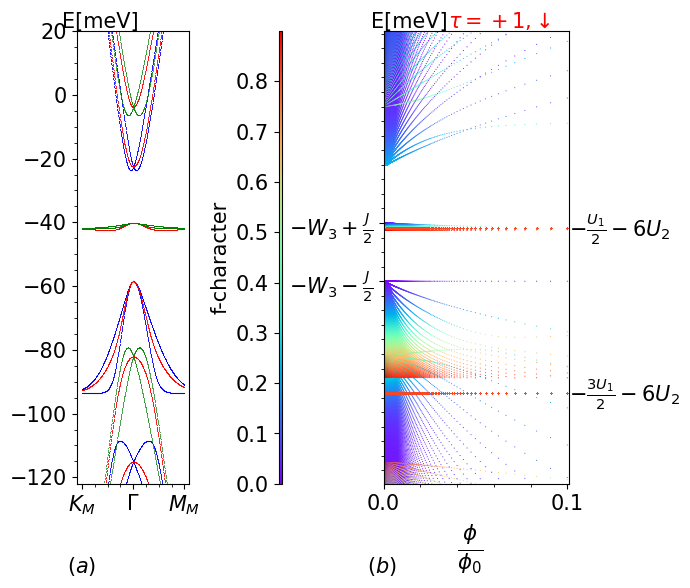

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from scipy import linalg
import matplotlib.pyplot as plt

import ctypes
from tqdm import tqdm
import warnings
import datetime
import time
import dataclasses
import os.path
import math
import matplotlib.cm as cm
from matplotlib import gridspec




##defining constants first based on bernvig_Song # w0/w1=0.7

theta = np.deg2rad(1.05) #default 1.05
pi = np.pi
j_mx = int(3)


a_lat = 2.46 #Angs
Lm = a_lat/(2*np.sin(theta/2)) #Angs
L1 = np.array([Lm*np.sqrt(3)/2,Lm/2])
L2 = np.array([0,Lm])
omega_m = np.sqrt(3)*(Lm**2)/2 #Angs^2
q_2 = (4*pi/(3*Lm))*np.array([np.sqrt(3)/2,1/2])
lambd = 0.3792*Lm #default 0.3792*Lm
gamma = -39.11 #mev
v_star_prime = 1624 #mev.Angs
v_star = -4483 #meV.Angs
U1 = 51.72 #mev default
J =  18.27 #mev default
M = 0#3.248 #mev default
W1 = 44.05
W3 = 49.33
U2 = 2.656


def assym_SVD1(m,y_br):
    
    m = int(m)
    if (m%2==0):
        return y_br**m
    else:
        return 0

def assym_SVD2(m,y_br,tau):
    
    sum_ = 0
    for k in range(1,m):
        if (m-k)%2==0:
            sum_ = sum_ + np.exp(m*np.log(m/(m-k)) + k*np.log((m-k)/k))*((tau/2)**k)*(y_br**(m-k))
        else:
            sum_ = sum_
    
    return sum_
    
def assymptotic_SVD(m_max,flux):
    
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
    
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
    
    zeta_2[0] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa)))
    for m in range(1,m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*((tau/2)**m + assym_SVD1(m,y_br) + assym_SVD2(m,y_br,tau)))
    
    return zeta_2

def two_hermite(x,y,n):
    H_n = 0
    n = int(n)
    for k in range(math.floor(n/2)+1):
        H_n = H_n + ((x**(n-2*k))*(y**k))/((math.factorial(n-2*k))*(math.factorial(k)))
    H_n = H_n*math.factorial(n)
    return H_n

def four_hermite(y_br,tau,n):
    H_n = 0
    n = int(n)
    for k in range(n+1):
        H_n = H_n + math.factorial(n)*(tau**k)*math.factorial(n)*(two_hermite(0,y_br,n-k)*two_hermite(0,y_br,n-k))/(math.factorial(n-k)*math.factorial(n-k)*math.factorial(k))
    return H_n        

def F_m(q, n, x0):
    
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    x0 = x0*L1[0] #angs
    F = ((np.sqrt((lb**2)/(lb**2 + lambd**2)))/((pi**0.25)*(np.sqrt((2**(float(n)))*(math.factorial(int(n)))))))*(np.exp(-1*(x0**2)/(2*(lb**2 + lambd**2))))*(two_hermite(-1*2*x0*lb/(lb**2 + lambd**2), 2*(lambd**2)/(lb**2 + lambd**2) - 1, n))                                           
    
    return F

def Io_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs

    I_O = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r- j*q)*(k2/2 - k1)) + (1j*pi*(r- j*q)*(r- j*q -1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_O[m,r] = np.sqrt(L1[0]/lb)*u
    
    return I_O

def twoMBZ(N):
    
    #pathI:KM->Gamma
    kxI = np.linspace(0,q_2[0],N)
    kyI = (1/np.sqrt(3))*kxI
    
    kxI = np.flip(kxI)
    kyI = np.flip(kyI)
    
    
    #pathII:Gamma+ -> Mm
    kxII = np.linspace(0,q_2[0],N)[1:]
    kyII = np.zeros(len(kxII))
        
    KX = np.concatenate((kxI,kxII),axis=None)
    KY = np.concatenate((kyI,kyII),axis=None)
    
    
    return KX,KY, len(kxI)-1

def zero_flux_nu1_spin_up_eta_K_ham(kx,ky):
    
    #nu=-1
    hK = np.zeros((6,6), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
    
    hK[0,2] = v_star*k
    hK[0,4] = ep_fac*gamma
    hK[0,5] = ep_fac*v_star_prime*k_br
    hK[1,3] = v_star*k_br
    hK[1,4] = ep_fac*v_star_prime*k
    hK[1,5] = ep_fac*gamma
    #Diagonal_divided by 2
    hK[0,0] = -W1/2
    hK[1,1] = -W1/2
    hK[2,2] = -W3/2 - J/4
    hK[3,3] = -W3/2 - J/4
    hK[4,4] = -3*U1/4 - 3*U2
    hK[5,5] = -3*U1/4 - 3*U2
    #mass term
    hK[2,3] = M
    
    hK = hK + np.transpose(np.conj(hK))

    eigvals, eigvecs = linalg.eigh(hK)
    
    return eigvals

def finitefieldHamiltonian_nu1_spindown_etaK(flux,m_max):
    
    m_max = int(m_max)
    
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux)
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num

    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*m_max +5+ 3+1, 6*m_max+5 + 3+1), dtype = np.complex128)
    
    #1x1
    h_low[0,0] = -W3/2 - J/4
    
    #3x3
    h_low[1,1] = -W1/2
    h_low[2,2] = -W3/2 - J/4
    h_low[3,3] = -3*U1/4 -3*U2
    h_low[1,2] = -1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
    
    #5x5
    h_low[4,4] = -W1/2
    h_low[5,5] = -W1/2
    h_low[6,6] = -W3/2 - J/4
    h_low[7,7] = -3*U1/4 - 3*U2
    h_low[8,8] = -U1/4 - 3*U2
    h_low[4,6] = -1j*2*v_star*lb_inv
    h_low[4,7] = gamma*zeta[1]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,8] = gamma*zeta[0]
    
    #6x6
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9] = -W1/2
        h_low[6*m+10,6*m+10] = -W1/2
        h_low[6*m+11,6*m+11] = -W3/2 - J/4
        h_low[6*m+12,6*m+12] = -W3/2 + J/4
        h_low[6*m+13,6*m+13] = -3*U1/4 - 3*U2
        h_low[6*m+14,6*m+14] = -U1/4 - 3*U2
        
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k-1]*lb_inv
        
        h_low[6*m+9+1, 6*m+9+3] = 1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9+1, 6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k]
        h_low[6*m+9+1, 6*m+9+5] = gamma*zeta[k-1]
        
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)

    eigvals, eigvecs = linalg.eigh(h_low)
    
    
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][3])**2 + np.abs(eigvecs[t][7])**2 + np.abs(eigvecs[t][8])**2
        for m in range(m_max):
            f_char[t] = f_char[t] + np.abs(eigvecs[t][6*m+13])**2 + np.abs(eigvecs[t][6*m+14])**2
    
    return eigvals , f_char   


def zero_flux_nu1_spin_down_eta_K_ham(kx,ky):
    
    hK = np.zeros((6,6), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
    
    hK[0,2] = v_star*k
    hK[0,4] = ep_fac*gamma
    hK[0,5] = ep_fac*v_star_prime*k_br
    hK[1,3] = v_star*k_br
    hK[1,4] = ep_fac*v_star_prime*k
    hK[1,5] = ep_fac*gamma
    #Diagonal_divided by 2
    hK[0,0] = -W1/2
    hK[1,1] = -W1/2
    hK[2,2] = -W3/2-J/4
    hK[3,3] = -W3/2+J/4
    hK[4,4] = -3*U1/4 - 3*U2
    hK[5,5] = -U1/4 - 3*U2
    #mass term
    hK[2,3] = M
    
    hK = hK + np.transpose(np.conj(hK))

    eigvals, eigvecs = linalg.eigh(hK)
    
    return eigvals 


def zero_flux_nu1_spin_up_eta_Kprime_ham(kx,ky):
    #same for spin down
    
    hK = np.zeros((6,6), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
    
    hK[0,2] = -v_star*k_br
    hK[0,4] = ep_fac*gamma
    hK[0,5] = -ep_fac*v_star_prime*k
    hK[1,3] = -v_star*k
    hK[1,4] = -ep_fac*v_star_prime*k_br
    hK[1,5] = ep_fac*gamma
    #Diagonal_divided by 2
    hK[0,0] = -W1/2
    hK[1,1] = -W1/2
    hK[2,2] = -W3/2 +J/4
    hK[3,3] = -W3/2 +J/4
    hK[4,4] = -U1/4 - 3*U2
    hK[5,5] = -U1/4 - 3*U2
    #mass term
    hK[2,3] = M
    
    hK = hK + np.transpose(np.conj(hK))

    eigvals, eigvecs = linalg.eigh(hK)
    
    return eigvals 

def get_spectrum_zerofield_nu1_spin_up_eta_K():
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),6), dtype = np.float64)
    

    for i in range(len(KX)):
        eigval_table[i]  = zero_flux_nu1_spin_up_eta_K_ham(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
    
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
    
    return k_points_lowb , e_point_lowb ,Km, Mm, Gm

def get_spectrum_zerofield_nu1_spin_down_eta_K():
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),6), dtype = np.float64)
    

    for i in range(len(KX)):
        eigval_table[i]  = zero_flux_nu1_spin_down_eta_K_ham(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
    
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
    
    return k_points_lowb , e_point_lowb ,Km, Mm, Gm

def get_spectrum_in_field_nu1_spin_down_eta_K():
    
    q_max = 700
    q_min = 10
    q_points = np.linspace(q_max,q_min,num=q_max-q_min+1,dtype=int)
    flux = np.zeros(len(q_points))
    m_max = np.zeros(len(q_points))
    
    for q in range(len(flux)):
        flux[q] = 1/q_points[q]
        m_max[q] = np.ceil((q_points[q]-3)/2) #5
    
    eigval, fchar = finitefieldHamiltonian_nu1_spindown_etaK(flux[0],m_max[0])
    pq_points_lowb = flux[0]*np.ones(len(eigval))

    for q in tqdm(range(1,len(flux))):
        eigs_upd, fchar_upd = finitefieldHamiltonian_nu1_spindown_etaK(flux[q],m_max[q])
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
        fchar = np.concatenate((fchar,fchar_upd),axis=None)
    
    e_point_lowb = eigval
    f_point_lowb = fchar
  
    return pq_points_lowb , e_point_lowb , f_point_lowb   


def get_spectrum_zerofield_nu1_spin_up_eta_Kprime(): #same for spin down
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),6), dtype = np.float64)
    

    for i in range(len(KX)):
        eigval_table[i]  = zero_flux_nu1_spin_up_eta_Kprime_ham(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
    
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
    
    return k_points_lowb , e_point_lowb ,Km, Mm, Gm

def plot_bandstructure_nu_minus1():
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
    k_points , e_point ,Km, Mm, Gm = get_spectrum_zerofield_nu1_spin_up_eta_K()
    k_pointsdwn , e_pointdwn ,Km, Mm, Gm = get_spectrum_zerofield_nu1_spin_down_eta_K()
    k_pointsK_prm , e_pointK_prm ,Km, Mm, Gm = get_spectrum_zerofield_nu1_spin_up_eta_Kprime()
    plt.subplot(gs[0])
    plt.scatter(k_points, e_point, color='blue', marker='o', lw=0,s=0.6)
    plt.scatter(k_pointsdwn, e_pointdwn, color='red', marker='o', lw=0,s=0.6)
    plt.scatter(k_pointsK_prm, e_pointK_prm, color='green', marker='o', lw=0,s=0.3)
    plt.xticks([Km, Gm, Mm],["$K_{M}$", "$\Gamma$","$M_{M}$"])
    plt.text(-115,21,"E[meV]",fontsize=15)
    plt.text(-90,-150,r'$(a)$',fontsize=15)
    plt.tick_params(axis='y', which='both', labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.ylim(-122,20)
    plt.minorticks_on()

   
    pq_points_lowb , e_point_lowb, f_point_lowb = get_spectrum_in_field_nu1_spin_down_eta_K()
    plt.subplot(gs[1])
    plt.scatter(pq_points_lowb, e_point_lowb,c= f_point_lowb, cmap = "rainbow", marker='o', lw=0,s=0.6)
    cbar = plt.colorbar(orientation="vertical",location='left',pad=0.3, shrink=1, aspect=120)
    cbar.set_label(label="f-character",size=15)
    cbar.ax.tick_params(labelsize=15)

    decoupled_f1 = (-3*U1/2-6*U2)*np.ones(len(pq_points_lowb))
    decoupled_f2 = (-U1/2-6*U2)*np.ones(len(pq_points_lowb))
    plt.scatter(pq_points_lowb, decoupled_f1, color='#ff4724', marker='o', lw=0.1,s=0.6)
    plt.scatter(pq_points_lowb, decoupled_f2, color='#ff4724', marker='o', lw=0.1,s=0.6)
    plt.text(-0.007,21,"E[meV]",fontsize=15)
    plt.text(0.035,21,r'$\tau=+1$,$\downarrow$',color='red',fontsize=15)
    plt.text(0.04,-145,r'$\frac{\phi}{\phi_0}$',fontsize=22)
    plt.text(-0.009,-150,r'$(b)$',fontsize=15)
    plt.tick_params(axis='y', which='both', labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.yticks([-W3-J/2,-W3+J/2],[r'$-W_3-\frac{J}{2}$',r'$-W_3+\frac{J}{2}$'])
    plt.text(0.101,-3*U1/2-6*U2-2.8,r'$-\frac{3U_1}{2}-6U_2$',color='black',fontsize=15)
    plt.text(0.101,-U1/2-6*U2-2.8,r'$-\frac{U_1}{2}-6U_2$' ,color='black',fontsize=15)

    plt.ylim(-122,20)
    plt.xlim(0,0.101)
    plt.gcf().set_size_inches((7,6))    
    plt.tight_layout()
    plt.minorticks_on()
    plt.savefig('Filling_negative_1_ab.pdf',bbox_inches='tight', dpi=1200)
    
if __name__ == '__main__':
    plot_bandstructure_nu_minus1()


100%|██████████| 690/690 [14:06<00:00,  1.23s/it]


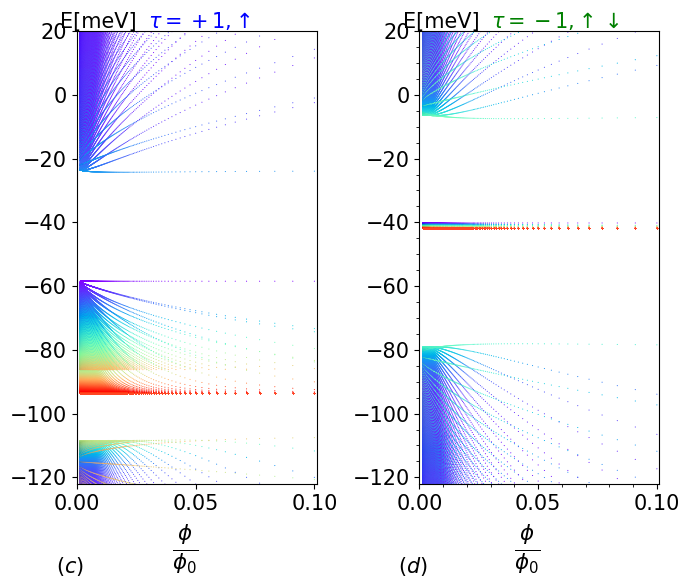

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from scipy import linalg
import matplotlib.pyplot as plt

import ctypes
from tqdm import tqdm
import warnings
import datetime
import time
import dataclasses
import os.path
import math
import matplotlib.cm as cm




##defining constants first based on bernvig_Song # w0/w1=0.7

theta = np.deg2rad(1.05) #default 1.05
pi = np.pi
j_mx = int(3)


a_lat = 2.46 #Angs
Lm = a_lat/(2*np.sin(theta/2)) #Angs
L1 = np.array([Lm*np.sqrt(3)/2,Lm/2])
L2 = np.array([0,Lm])
omega_m = np.sqrt(3)*(Lm**2)/2 #Angs^2
q_2 = (4*pi/(3*Lm))*np.array([np.sqrt(3)/2,1/2])
lambd = 0.3792*Lm #default 0.3792*Lm
gamma = -39.11 #mev
v_star_prime = 1624 #mev.Angs
v_star = -4483 #meV.Angs
U1 = 51.72 #mev default
J =  18.27 #mev default
M = 0#3.248 #mev default
W1 = 44.05
W3 = 49.33
U2 = 2.656


def assym_SVD1(m,y_br):
   
    m = int(m)
    if (m%2==0):
        return y_br**m
    else:
        return 0

def assym_SVD2(m,y_br,tau):
   
    sum_ = 0
    for k in range(1,m):
        if (m-k)%2==0:
            sum_ = sum_ + np.exp(m*np.log(m/(m-k)) + k*np.log((m-k)/k))*((tau/2)**k)*(y_br**(m-k))
        else:
            sum_ = sum_
   
    return sum_
   
def assymptotic_SVD(m_max,flux):
   
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
   
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
   
    zeta_2[0] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa)))
    for m in range(1,m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*((tau/2)**m + assym_SVD1(m,y_br) + assym_SVD2(m,y_br,tau)))
   
    return zeta_2

def two_hermite(x,y,n):
    H_n = 0
    n = int(n)
    for k in range(math.floor(n/2)+1):
        H_n = H_n + ((x**(n-2*k))*(y**k))/((math.factorial(n-2*k))*(math.factorial(k)))
    H_n = H_n*math.factorial(n)
    return H_n

def four_hermite(y_br,tau,n):
    H_n = 0
    n = int(n)
    for k in range(n+1):
        H_n = H_n + math.factorial(n)*(tau**k)*math.factorial(n)*(two_hermite(0,y_br,n-k)*two_hermite(0,y_br,n-k))/(math.factorial(n-k)*math.factorial(n-k)*math.factorial(k))
    return H_n        

def F_m(q, n, x0):
   
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    x0 = x0*L1[0] #angs
    F = ((np.sqrt((lb**2)/(lb**2 + lambd**2)))/((pi**0.25)*(np.sqrt((2**(float(n)))*(math.factorial(int(n)))))))*(np.exp(-1*(x0**2)/(2*(lb**2 + lambd**2))))*(two_hermite(-1*2*x0*lb/(lb**2 + lambd**2), 2*(lambd**2)/(lb**2 + lambd**2) - 1, n))                                          
   
    return F

def Io_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs

    I_O = np.zeros((m_max+2, q), dtype=np.complex128)
   
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r- j*q)*(k2/2 - k1)) + (1j*pi*(r- j*q)*(r- j*q -1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_O[m,r] = np.sqrt(L1[0]/lb)*u
   
    return I_O

def twoMBZ(N):
   
    #pathI:KM->Gamma
    kxI = np.linspace(0,q_2[0],N)
    kyI = (1/np.sqrt(3))*kxI
   
    kxI = np.flip(kxI)
    kyI = np.flip(kyI)
   
   
    #pathII:Gamma+ -> Mm
    kxII = np.linspace(0,q_2[0],N)[1:]
    kyII = np.zeros(len(kxII))
       
    KX = np.concatenate((kxI,kxII),axis=None)
    KY = np.concatenate((kyI,kyII),axis=None)
   
   
    return KX,KY, len(kxI)-1

def finitefieldHamiltonian_nu1_spinup_etaK(flux,m_max):
   
    m_max = int(m_max)
   
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux)
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num

    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*m_max +5+ 3+1, 6*m_max+5 + 3+1), dtype = np.complex128)
   
    #1x1
    h_low[0,0] = -W3/2 - J/4
   
    #3x3
    h_low[1,1] = -W1/2
    h_low[2,2] = -W3/2 - J/4
    h_low[3,3] = -3*U1/4 -3*U2
    h_low[1,2] = -1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
   
    #5x5
    h_low[4,4] = -W1/2
    h_low[5,5] = -W1/2
    h_low[6,6] = -W3/2 - J/4
    h_low[7,7] = -3*U1/4 - 3*U2
    h_low[8,8] = -3*U1/4 - 3*U2
    h_low[4,6] = -1j*2*v_star*lb_inv
    h_low[4,7] = gamma*zeta[1]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,8] = gamma*zeta[0]
   
    #6x6
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9] = -W1/2
        h_low[6*m+10,6*m+10] = -W1/2
        h_low[6*m+11,6*m+11] = -W3/2 - J/4
        h_low[6*m+12,6*m+12] = -W3/2 - J/4
        h_low[6*m+13,6*m+13] = -3*U1/4 - 3*U2
        h_low[6*m+14,6*m+14] = -3*U1/4 - 3*U2
       
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k-1]*lb_inv
       
        h_low[6*m+9+1, 6*m+9+3] = 1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9+1, 6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k]
        h_low[6*m+9+1, 6*m+9+5] = gamma*zeta[k-1]
       
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)

    eigvals, eigvecs = linalg.eigh(h_low)
   
   
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][3])**2 + np.abs(eigvecs[t][7])**2 + np.abs(eigvecs[t][8])**2
        for m in range(m_max):
            f_char[t] = f_char[t] + np.abs(eigvecs[t][6*m+13])**2 + np.abs(eigvecs[t][6*m+14])**2
   
    return eigvals , f_char  


def zero_flux_nu1_spin_up_eta_K_ham(kx,ky):
   
    #nu=-1
    hK = np.zeros((6,6), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
   
    hK[0,2] = v_star*k
    hK[0,4] = ep_fac*gamma
    hK[0,5] = ep_fac*v_star_prime*k_br
    hK[1,3] = v_star*k_br
    hK[1,4] = ep_fac*v_star_prime*k
    hK[1,5] = ep_fac*gamma
    #Diagonal_divided by 2
    hK[0,0] = -W1/2
    hK[1,1] = -W1/2
    hK[2,2] = -W3/2 - J/4
    hK[3,3] = -W3/2 - J/4
    hK[4,4] = -3*U1/4 - 3*U2
    hK[5,5] = -3*U1/4 - 3*U2
    #mass term
    hK[2,3] = M
   
    hK = hK + np.transpose(np.conj(hK))

    eigvals, eigvecs = linalg.eigh(hK)
   
    return eigvals 


def finitefieldHamiltonian_nu1_spindown_etaK(flux,m_max):
   
    m_max = int(m_max)
   
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux)
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num

    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*m_max +5+ 3+1, 6*m_max+5 + 3+1), dtype = np.complex128)
   
    #1x1
    h_low[0,0] = -W3/2 - J/4
   
    #3x3
    h_low[1,1] = -W1/2
    h_low[2,2] = -W3/2 - J/4
    h_low[3,3] = -3*U1/4 -3*U2
    h_low[1,2] = -1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
   
    #5x5
    h_low[4,4] = -W1/2
    h_low[5,5] = -W1/2
    h_low[6,6] = -W3/2 - J/4
    h_low[7,7] = -3*U1/4 - 3*U2
    h_low[8,8] = -U1/4 - 3*U2
    h_low[4,6] = -1j*2*v_star*lb_inv
    h_low[4,7] = gamma*zeta[1]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,8] = gamma*zeta[0]
   
    #6x6
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9] = -W1/2
        h_low[6*m+10,6*m+10] = -W1/2
        h_low[6*m+11,6*m+11] = -W3/2 - J/4
        h_low[6*m+12,6*m+12] = -W3/2 + J/4
        h_low[6*m+13,6*m+13] = -3*U1/4 - 3*U2
        h_low[6*m+14,6*m+14] = -U1/4 - 3*U2
       
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k-1]*lb_inv
       
        h_low[6*m+9+1, 6*m+9+3] = 1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9+1, 6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k]
        h_low[6*m+9+1, 6*m+9+5] = gamma*zeta[k-1]
       
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)

    eigvals, eigvecs = linalg.eigh(h_low)
   
   
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][3])**2 + np.abs(eigvecs[t][7])**2 + np.abs(eigvecs[t][8])**2
        for m in range(m_max):
            f_char[t] = f_char[t] + np.abs(eigvecs[t][6*m+13])**2 + np.abs(eigvecs[t][6*m+14])**2
   
    return eigvals , f_char  

def zero_flux_nu1_spin_down_eta_K_ham(kx,ky):
   
    hK = np.zeros((6,6), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
   
    hK[0,2] = v_star*k
    hK[0,4] = ep_fac*gamma
    hK[0,5] = ep_fac*v_star_prime*k_br
    hK[1,3] = v_star*k_br
    hK[1,4] = ep_fac*v_star_prime*k
    hK[1,5] = ep_fac*gamma
    #Diagonal_divided by 2
    hK[0,0] = -W1/2
    hK[1,1] = -W1/2
    hK[2,2] = -W3/2-J/4
    hK[3,3] = -W3/2+J/4
    hK[4,4] = -3*U1/4 - 3*U2
    hK[5,5] = -U1/4 - 3*U2
    #mass term
    hK[2,3] = M
   
    hK = hK + np.transpose(np.conj(hK))

    eigvals, eigvecs = linalg.eigh(hK)
       
    return eigvals 


def finitefieldHamiltonian_nu1_spinup_etaKprime(flux,m_max):
    #Same for spin down
    m_max = int(m_max)
   
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux)
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num

    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*m_max +5+ 3+1, 6*m_max+5 + 3+1), dtype = np.complex128)
   
    #1x1
    h_low[0,0] = -W3/2 + J/4
   
    #3x3
    h_low[1,1] = -W1/2
    h_low[2,2] = -W3/2 + J/4
    h_low[3,3] = -U1/4 -3*U2
    h_low[1,2] = 1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
   
    #5x5
    h_low[4,4] = -W1/2
    h_low[5,5] = -W1/2
    h_low[6,6] = -W3/2 + J/4
    h_low[7,7] = -U1/4 - 3*U2
    h_low[8,8] = -U1/4 - 3*U2
    h_low[4,7] = gamma*zeta[0]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,6] = 1j*2*v_star*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,8] = gamma*zeta[1]
   
    #6x6
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9] = -W1/2
        h_low[6*m+10,6*m+10] = -W1/2
        h_low[6*m+11,6*m+11] = -W3/2 + J/4
        h_low[6*m+12,6*m+12] = -W3/2 + J/4
        h_low[6*m+13,6*m+13] = -U1/4 - 3*U2
        h_low[6*m+14,6*m+14] = -U1/4 - 3*U2
       
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k-1]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k]*lb_inv
       
        h_low[6*m+9+1, 6*m+9+3] = 1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9+1, 6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k-1]
        h_low[6*m+9+1, 6*m+9+5] = gamma*zeta[k]
       
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)

    eigvals, eigvecs = linalg.eigh(h_low)
   
   
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][3])**2 + np.abs(eigvecs[t][7])**2 + np.abs(eigvecs[t][8])**2
        for m in range(m_max):
            f_char[t] = f_char[t] + np.abs(eigvecs[t][6*m+13])**2 + np.abs(eigvecs[t][6*m+14])**2
   
    return eigvals , f_char  


def zero_flux_nu1_spin_up_eta_Kprime_ham(kx,ky):
    #same for spin down
   
    hK = np.zeros((6,6), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
   
    hK[0,2] = -v_star*k_br
    hK[0,4] = ep_fac*gamma
    hK[0,5] = -ep_fac*v_star_prime*k
    hK[1,3] = -v_star*k
    hK[1,4] = -ep_fac*v_star_prime*k_br
    hK[1,5] = ep_fac*gamma
    #Diagonal_divided by 2
    hK[0,0] = -W1/2
    hK[1,1] = -W1/2
    hK[2,2] = -W3/2 +J/4
    hK[3,3] = -W3/2 +J/4
    hK[4,4] = -U1/4 - 3*U2
    hK[5,5] = -U1/4 - 3*U2
    #mass term
    hK[2,3] = M
   
    hK = hK + np.transpose(np.conj(hK))

    eigvals, eigvecs = linalg.eigh(hK)
    
    return eigvals 

def get_spectrum_zerofield_nu1_spin_up_eta_K():
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),6), dtype = np.float64)
   

    for i in range(len(KX)):
        eigval_table[i]  = zero_flux_nu1_spin_up_eta_K_ham(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
   
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
   
    return k_points_lowb , e_point_lowb ,Km, Mm, Gm

def get_spectrum_in_field_nu1_spin_up_eta_K():
   
    q_max = 700
    q_min = 10
    q_points = np.linspace(q_max,q_min,num=q_max-q_min+1,dtype=int)
    flux = np.zeros(len(q_points))
    m_max = np.zeros(len(q_points))
   
    for q in range(len(flux)):
        flux[q] = 1/q_points[q]
        m_max[q] = np.ceil((q_points[q]-3)/2) #5
   
    eigval, fchar = finitefieldHamiltonian_nu1_spinup_etaK(flux[0],m_max[0])
    pq_points_lowb = flux[0]*np.ones(len(eigval))

    for q in tqdm(range(1,len(flux))):
        eigs_upd, fchar_upd = finitefieldHamiltonian_nu1_spinup_etaK(flux[q],m_max[q])
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
        fchar = np.concatenate((fchar,fchar_upd),axis=None)
   
    e_point_lowb = eigval
    f_point_lowb = fchar
 
    return pq_points_lowb , e_point_lowb , f_point_lowb  


def get_spectrum_zerofield_nu1_spin_down_eta_K():
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),6), dtype = np.float64)
   

    for i in range(len(KX)):
        eigval_table[i]  = zero_flux_nu1_spin_down_eta_K_ham(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
   
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
   
    return k_points_lowb , e_point_lowb ,Km, Mm, Gm

def get_spectrum_in_field_nu1_spin_down_eta_K():
   
    q_max = 700
    q_min = 10
    q_points = np.linspace(q_max,q_min,num=q_max-q_min+1,dtype=int)
    flux = np.zeros(len(q_points))
    m_max = np.zeros(len(q_points))
   
    for q in range(len(flux)):
        flux[q] = 1/q_points[q]
        m_max[q] = np.ceil((q_points[q]-3)/2) #5
   
    eigval, fchar = finitefieldHamiltonian_nu1_spindown_etaK(flux[0],m_max[0])
    pq_points_lowb = flux[0]*np.ones(len(eigval))

    for q in tqdm(range(1,len(flux))):
        eigs_upd, fchar_upd = finitefieldHamiltonian_nu1_spindown_etaK(flux[q],m_max[q])
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
        fchar = np.concatenate((fchar,fchar_upd),axis=None)
   
    e_point_lowb = eigval
    f_point_lowb = fchar
 
    return pq_points_lowb , e_point_lowb , f_point_lowb  


def get_spectrum_zerofield_nu1_spin_up_eta_Kprime(): #same for spin down
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),6), dtype = np.float64)
   

    for i in range(len(KX)):
        eigval_table[i]  = zero_flux_nu1_spin_up_eta_Kprime_ham(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
   
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
   
    return k_points_lowb , e_point_lowb ,Km, Mm, Gm

def get_spectrum_in_field_nu1_spin_up_eta_Kprime():
   
    q_max = 700
    q_min = 10
    q_points = np.linspace(q_max,q_min,num=q_max-q_min+1,dtype=int)
    flux = np.zeros(len(q_points))
    m_max = np.zeros(len(q_points))
   
    for q in range(len(flux)):
        flux[q] = 1/q_points[q]
        m_max[q] = np.ceil((q_points[q]-3)/2) #5
   
    eigval, fchar = finitefieldHamiltonian_nu1_spinup_etaKprime(flux[0],m_max[0])
    pq_points_lowb = flux[0]*np.ones(len(eigval))

    for q in tqdm(range(1,len(flux))):
        eigs_upd, fchar_upd = finitefieldHamiltonian_nu1_spinup_etaKprime(flux[q],m_max[q])
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
        fchar = np.concatenate((fchar,fchar_upd),axis=None)
   
    e_point_lowb = eigval
    f_point_lowb = fchar
 
    return pq_points_lowb , e_point_lowb , f_point_lowb  


def plot_bandstructure_nu_minus1():
   
   
    pq_points_lowbKup , e_point_lowbKup, f_point_lowbKup = get_spectrum_in_field_nu1_spin_up_eta_K()
    decoupled_Kup = (-3*U1/2-6*U2)*np.ones(len(pq_points_lowbKup))
    plt.subplot(1,2,1)
    plt.scatter(pq_points_lowbKup, e_point_lowbKup,c= f_point_lowbKup, cmap = "rainbow", marker='o', lw=0,s=0.6)
    plt.scatter(pq_points_lowbKup, decoupled_Kup, color='#ff4724', marker='o', lw=0.1,s=0.6)
    plt.text(-0.007,21,"E[meV]",fontsize=15)
    plt.text(0.03,21,r'$\tau=+1$,$\uparrow$',color='blue',fontsize=15)
    plt.text(0.04,-145,r'$\frac{\phi}{\phi_0}$',fontsize=22)
    plt.text(-0.009,-150,r'$(c)$',fontsize=15)
    plt.tick_params(axis='y', which='both', labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.ylim(-122,20)
    plt.xlim(0,0.101)
    



   
    pq_points_lowbKprup , e_point_lowbKprup, f_point_lowbKpup = get_spectrum_in_field_nu1_spin_up_eta_Kprime()
    decoupled_Kprup = (-U1/2-6*U2)*np.ones(len(pq_points_lowbKprup))
    plt.subplot(1,2,2)
    plt.scatter(pq_points_lowbKprup, e_point_lowbKprup,c= f_point_lowbKpup, cmap = "rainbow", marker='o', lw=0,s=0.6)
    plt.scatter(pq_points_lowbKprup, decoupled_Kprup, color='#ff4724', marker='o', lw=0.1,s=0.6)
    plt.text(-0.007,21,"E[meV]",fontsize=15)
    plt.text(0.03,21,r'$\tau=-1$,$\uparrow\downarrow$',color='green',fontsize=15)
    plt.text(0.04,-145,r'$\frac{\phi}{\phi_0}$',fontsize=22)
    plt.text(-0.009,-150,r'$(d)$',fontsize=15)
    plt.tick_params(axis='y', which='both', labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.ylim(-122,20)
    plt.xlim(0,0.101)
    
    plt.gcf().set_size_inches((7,6))    
    plt.tight_layout()
    plt.minorticks_on()
    plt.savefig('Filling_negative_1_cd.pdf',bbox_inches='tight', dpi=1200)

       
if __name__ == '__main__':
    plot_bandstructure_nu_minus1()


100%|██████████| 690/690 [14:12<00:00,  1.24s/it]


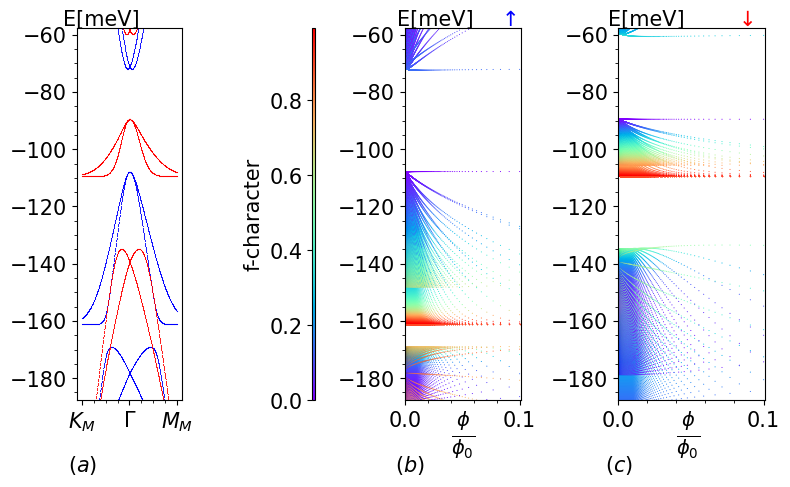

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from scipy import linalg
import matplotlib.pyplot as plt

import ctypes
from tqdm import tqdm
import warnings
import datetime
import time
import dataclasses
import os.path
import math
import matplotlib.cm as cm
from matplotlib import gridspec




##defining constants first based on bernvig_Song # w0/w1=0.7

theta = np.deg2rad(1.05) #default 1.05
pi = np.pi
j_mx = int(3)


a_lat = 2.46 #Angs
Lm = a_lat/(2*np.sin(theta/2)) #Angs
L1 = np.array([Lm*np.sqrt(3)/2,Lm/2])
L2 = np.array([0,Lm])
omega_m = np.sqrt(3)*(Lm**2)/2 #Angs^2
q_2 = (4*pi/(3*Lm))*np.array([np.sqrt(3)/2,1/2])
lambd = 0.3792*Lm #default 0.3792*Lm
gamma = -39.11 #mev
v_star_prime = 1624 #mev.Angs
v_star = -4483 #meV.Angs
U1 = 51.72 #mev default
J =  18.27 #mev default
M = 0#3.248 #mev default
W1 = 44.05
W3 = 49.33
U2 = 2.656



def twoMBZ(N):
    
    #pathI:KM->Gamma
    kxI = np.linspace(0,q_2[0],N)
    kyI = (1/np.sqrt(3))*kxI
    
    kxI = np.flip(kxI)
    kyI = np.flip(kyI)
    
    
    #pathII:Gamma+ -> Mm
    kxII = np.linspace(0,q_2[0],N)[1:]
    kyII = np.zeros(len(kxII))
        
    KX = np.concatenate((kxI,kxII),axis=None)
    KY = np.concatenate((kyI,kyII),axis=None)
    
    
    return KX,KY, len(kxI)-1



def assym_SVD1(m,y_br):
    
    m = int(m)
    if (m%2==0):
        return y_br**m
    else:
        return 0

def assym_SVD2(m,y_br,tau):
    
    sum_ = 0
    for k in range(1,m):
        if (m-k)%2==0:
            sum_ = sum_ + np.exp(m*np.log(m/(m-k)) + k*np.log((m-k)/k))*((tau/2)**k)*(y_br**(m-k))
        else:
            sum_ = sum_
    
    return sum_
    
def assymptotic_SVD(m_max,flux):
    
    kppa = 2*pi*(lambd**2)*flux/omega_m
    tau = 2/((1 + kppa + kppa**2)*(1 + kppa))
    y_br = (kppa - 1 + 1/(1 + kppa + kppa**2))/(1 + kppa)
    f = (1 + kppa + kppa**2)/(1 + kppa)
    
    zeta_2 = np.zeros(m_max+4, dtype=np.float64)
    
    zeta_2[0] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa)))
    for m in range(1,m_max+4):
        zeta_2[m] = np.sqrt(np.sqrt(1/f)*(1/(1 + kppa))*((tau/2)**m + assym_SVD1(m,y_br) + assym_SVD2(m,y_br,tau)))
    
    return zeta_2

def two_hermite(x,y,n):
    H_n = 0
    n = int(n)
    for k in range(math.floor(n/2)+1):
        H_n = H_n + ((x**(n-2*k))*(y**k))/((math.factorial(n-2*k))*(math.factorial(k)))
    H_n = H_n*math.factorial(n)
    return H_n

def four_hermite(y_br,tau,n):
    H_n = 0
    n = int(n)
    for k in range(n+1):
        H_n = H_n + math.factorial(n)*(tau**k)*math.factorial(n)*(two_hermite(0,y_br,n-k)*two_hermite(0,y_br,n-k))/(math.factorial(n-k)*math.factorial(n-k)*math.factorial(k))
    return H_n        

def F_m(q, n, x0):
    
    lb = (omega_m*q/(2*pi))**(1/2) #Angs
    x0 = x0*L1[0] #angs
    F = ((np.sqrt((lb**2)/(lb**2 + lambd**2)))/((pi**0.25)*(np.sqrt((2**(float(n)))*(math.factorial(int(n)))))))*(np.exp(-1*(x0**2)/(2*(lb**2 + lambd**2))))*(two_hermite(-1*2*x0*lb/(lb**2 + lambd**2), 2*(lambd**2)/(lb**2 + lambd**2) - 1, n))                                           
    
    return F

def Io_builder(k1,k2,m_max,q):
    m_max = int(m_max)
    q = int(q)
    k2 = k2
    k1 = k1
    lb = (omega_m*q/(2*pi))**(1/2) #Angs

    I_O = np.zeros((m_max+2, q), dtype=np.complex128)
    
    for m in range(m_max + 2):
        for r in range(q):
            u = 0
            for j in range(-j_mx,j_mx+1):
                u = u + np.exp((2*pi*1j*(r- j*q)*(k2/2 - k1)) + (1j*pi*(r- j*q)*(r- j*q -1)/(2*q)) - (2*(pi**2)*(lambd**2)*((k2 + r/q -j)**2)/(Lm**2)))*(F_m(q, m, (-j+k2)*q + r))
            I_O[m,r] = np.sqrt(L1[0]/lb)*u
    
    return I_O

def zero_flux_nu2_spin_up_eta_K_ham(kx,ky):
    
    hK = np.zeros((6,6), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
    hK[2,3] = 0#M
    hK[0,2] = v_star*k
    hK[0,4] = ep_fac*gamma
    hK[0,5] = ep_fac*v_star_prime*k_br
    hK[1,3] = v_star*k_br
    hK[1,4] = ep_fac*v_star_prime*k
    hK[1,5] = ep_fac*gamma
    #Diagonal_divided by 2
    hK[0,0] = -W1
    hK[1,1] = -W1
    hK[2,2] = -W3 -J/4
    hK[3,3] = -W3 -J/4
    hK[4,4] = -5*U1/4 - 6*U2
    hK[5,5] = -5*U1/4 - 6*U2
    
    hK = hK + np.transpose(np.conj(hK))

    eigvals, eigvecs = linalg.eigh(hK)
    
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][4])**2 + np.abs(eigvecs[t][5])**2# + np.abs(eigvecs[t][10])**2 + np.abs(eigvecs[t][11])**2
    
    return eigvals , f_char

def finitefieldHamiltonian_nu2_spinup_etaK(flux,m_max): #this all is for \nu=-2
    
    m_max = int(m_max)
    
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux)
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num

    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*m_max +5+ 3+1, 6*m_max+5 + 3+1), dtype = np.complex128)
    
    #1x1
    h_low[0,0] = -W3 - J/4
    
    #3x3
    h_low[1,1] = -W1
    h_low[2,2] = -W3 -J/4
    h_low[3,3] = -5*U1/4 -6*U2
    h_low[1,2] = -1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
    
    #5x5
    h_low[4,4] = -W1
    h_low[5,5] = -W1
    h_low[6,6] = -W3 - J/4
    h_low[7,7] = -5*U1/4 - 6*U2
    h_low[8,8] = -5*U1/4 - 6*U2
    h_low[4,6] = -1j*2*v_star*lb_inv
    h_low[4,7] = gamma*zeta[1]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,8] = gamma*zeta[0]
    
    #6x6
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9] = -W1
        h_low[6*m+10,6*m+10] = -W1
        h_low[6*m+11,6*m+11] = -W3-J/4
        h_low[6*m+12,6*m+12] = -W3-J/4
        h_low[6*m+13,6*m+13] = -5*U1/4 - 6*U2
        h_low[6*m+14,6*m+14] = -5*U1/4 - 6*U2
        
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k-1]*lb_inv
        
        h_low[6*m+9+1, 6*m+9+3] = 1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9+1, 6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k]
        h_low[6*m+9+1, 6*m+9+5] = gamma*zeta[k-1]
    

    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)

    eigvals, eigvecs = linalg.eigh(h_low)
    
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][3])**2 + np.abs(eigvecs[t][7])**2 + np.abs(eigvecs[t][8])**2
        for m in range(m_max):
            f_char[t] = f_char[t] + np.abs(eigvecs[t][6*m+13])**2 + np.abs(eigvecs[t][6*m+14])**2
    
    
    return eigvals , f_char


def zero_flux_nu2_spin_down_eta_K_ham(kx,ky):
    
    hK = np.zeros((6,6), dtype=np.complex128)
    k_br = kx - 1j*ky
    k = kx + 1j*ky
    ep_fac = np.exp(-0.5*(kx**2+ky**2)*(lambd**2))
    #hK[2,3] = M
    hK[0,2] = v_star*k
    hK[0,4] = ep_fac*gamma
    hK[0,5] = ep_fac*v_star_prime*k_br
    hK[1,3] = v_star*k_br
    hK[1,4] = ep_fac*v_star_prime*k
    hK[1,5] = ep_fac*gamma
    #Diagonal_divided by 2
    hK[0,0] = -W1
    hK[1,1] = -W1
    hK[2,2] = -W3 +J/4
    hK[3,3] = -W3 +J/4
    hK[4,4] = -3*U1/4 - 6*U2
    hK[5,5] = -3*U1/4 - 6*U2
    
    hK = hK + np.transpose(np.conj(hK))

    eigvals, eigvecs = linalg.eigh(hK)
    
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][4])**2 + np.abs(eigvecs[t][5])**2 #+ np.abs(eigvecs[t][10])**2 + np.abs(eigvecs[t][11])**2

    
    return eigvals , f_char

def finitefieldHamiltonian_nu2_spindown_etaK(flux,m_max):
    
    m_max = int(m_max)
    
    ##Fixing Singular values here #zeta = omega0_builder(m_max,flux)
    if flux<0.05:
        zeta = assymptotic_SVD(m_max,flux)
    else:
        q = int(1/flux)
        I_0 = Io_builder(0,0,m_max+2,q)
        U, zeta_num, Vh = linalg.svd(I_0)
        zeta = zeta_num

    lb_inv = (2*pi*flux/omega_m)**(1/2)
    h_low = np.zeros((6*m_max +5+ 3+1, 6*m_max+5 + 3+1), dtype = np.complex128)
    
    #1x1
    h_low[0,0] = -W3 + J/4
    
    #3x3
    h_low[1,1] = -W1
    h_low[2,2] = -W3 +J/4
    h_low[3,3] = -3*U1/4 -6*U2
    h_low[1,2] = -1j*np.sqrt(2)*v_star*lb_inv
    h_low[1,3] = gamma*zeta[0]
    
    #5x5
    h_low[4,4] = -W1
    h_low[5,5] = -W1
    h_low[6,6] = -W3 + J/4
    h_low[7,7] = -3*U1/4 - 6*U2
    h_low[8,8] = -3*U1/4 - 6*U2
    h_low[4,6] = -1j*2*v_star*lb_inv
    h_low[4,7] = gamma*zeta[1]
    h_low[4,8] = 1j*np.sqrt(2)*v_star_prime*zeta[0]*lb_inv
    h_low[5,7] = -1j*np.sqrt(2)*v_star_prime*zeta[1]*lb_inv
    h_low[5,8] = gamma*zeta[0]
    
    #6x6
    for m in range(m_max):
        k = m+2
        h_low[6*m+9,6*m+9] = -W1
        h_low[6*m+10,6*m+10] = -W1
        h_low[6*m+11,6*m+11] = -W3+J/4
        h_low[6*m+12,6*m+12] = -W3+J/4
        h_low[6*m+13,6*m+13] = -3*U1/4 - 6*U2
        h_low[6*m+14,6*m+14] = -3*U1/4 - 6*U2
        
        h_low[6*m+9,6*m+9+2] = -1j*np.sqrt(2*k+2)*v_star*lb_inv
        h_low[6*m+9,6*m+9+4] = gamma*zeta[k]
        h_low[6*m+9,6*m+9+5] = 1j*np.sqrt(2*k)*v_star_prime*zeta[k-1]*lb_inv
        
        h_low[6*m+9+1, 6*m+9+3] = 1j*np.sqrt(2*k-2)*v_star*lb_inv
        h_low[6*m+9+1, 6*m+9+4] = -1j*np.sqrt(2*k)*v_star_prime*lb_inv*zeta[k]
        h_low[6*m+9+1, 6*m+9+5] = gamma*zeta[k-1]
    
    
    h_low = h_low + np.transpose(np.conj(h_low))
    argnan = np.argwhere(np.isnan(h_low))
    if argnan.size > 0:
        raise ValueError('Nan value caught in h')
        print("Don't give up",q)

    eigvals, eigvecs = linalg.eigh(h_low)
    
    eigvecs = np.transpose(eigvecs)
    f_char = np.zeros((len(eigvals)), dtype=np.float64)

    for t in range(len(eigvals)):
        f_char[t] = np.abs(eigvecs[t][3])**2 + np.abs(eigvecs[t][7])**2 + np.abs(eigvecs[t][8])**2
        for m in range(m_max):
            f_char[t] = f_char[t] + np.abs(eigvecs[t][6*m+13])**2 + np.abs(eigvecs[t][6*m+14])**2
    
    
    return eigvals , f_char   


def get_spectrum_zerofield_nu2_spin_up_eta_K():
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),6), dtype = np.float64)
    fchar_table = np.zeros((len(KX),6), dtype = np.float64)
    

    for i in range(len(KX)):
        eigval_table[i], fchar_table[i] = zero_flux_nu2_spin_up_eta_K_ham(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
    
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
    f_point_lowb = fchar_table.flatten()
    
    return k_points_lowb , e_point_lowb ,f_point_lowb, Km, Mm, Gm

def get_spectrum_zerofield_nu2_spin_down_eta_K():
    N = 300
    KX,KY, Gm = twoMBZ(N)
    Km = 0
    Mm = len(KX)-1
    eigval_table = np.zeros((len(KX),6), dtype = np.float64)
    fchar_table = np.zeros((len(KX),6), dtype = np.float64)
    

    for i in range(len(KX)):
        eigval_table[i], fchar_table[i]  = zero_flux_nu2_spin_down_eta_K_ham(KX[i],KY[i])

    k_points_lowb = np.zeros(len(eigval_table[0]))
    
    for i in range(1,len(KX)):
        k_points_lowb = np.concatenate((k_points_lowb,i*np.ones(len(eigval_table[0]))), axis=None)
       
    e_point_lowb = eigval_table.flatten()
    f_point_lowb = fchar_table.flatten()
    
    return k_points_lowb , e_point_lowb ,f_point_lowb, Km, Mm, Gm

def count_state(spin,q,eigvals):
    count = 0
    if spin==-1:
        for t in range(len(eigvals)):
            if eigvals[t]>-120:
                if eigvals[t]<-80:
                    count = count+1
                    
    if spin==+1:
        for t in range(len(eigvals)):
            if eigvals[t]>-165:
                if eigvals[t]<-100:
                    count = count+1
                    
    print(spin,q,count)

        
def get_spectrum_in_field_nu2_spin_up_eta_K():
    q_max = 700
    q_min = 10
    q_points = np.linspace(q_max,q_min,num=q_max-q_min+1,dtype=int)
    flux = np.zeros(len(q_points))
    m_max = np.zeros(len(q_points))
    for q in range(len(flux)):
        flux[q] = 1/q_points[q]
        m_max[q] = np.ceil((q_points[q]-3)/2)
    
    eigval, fchar = finitefieldHamiltonian_nu2_spinup_etaK(flux[0],m_max[0])

    pq_points_lowb = flux[0]*np.ones(len(eigval))

    for q in tqdm(range(1,len(flux))):
        eigs_upd, fchar_upd = finitefieldHamiltonian_nu2_spinup_etaK(flux[q],m_max[q])
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
        fchar = np.concatenate((fchar,fchar_upd),axis=None)
    
    e_point_lowb = eigval
    f_point_lowb = fchar
  
    return pq_points_lowb , e_point_lowb, f_point_lowb
 
    

def get_spectrum_in_field_nu2_spin_down_eta_K():
    q_max = 700
    q_min = 10
    q_points = np.linspace(q_max,q_min,num=q_max-q_min+1,dtype=int)
    flux = np.zeros(len(q_points))
    m_max = np.zeros(len(q_points))
    for q in range(len(flux)):
        flux[q] = 1/q_points[q]
        m_max[q] = np.ceil((q_points[q]-3)/2)
    
    eigval, fchar = finitefieldHamiltonian_nu2_spindown_etaK(flux[0],m_max[0])
    pq_points_lowb = flux[0]*np.ones(len(eigval))

    for q in tqdm(range(1,len(flux))):
        eigs_upd, fchar_upd = finitefieldHamiltonian_nu2_spindown_etaK(flux[q],m_max[q])
        pq_points_lowb = np.concatenate((pq_points_lowb,flux[q]*np.ones(len(eigs_upd))), axis=None)
        eigval = np.concatenate((eigval,eigs_upd), axis=None)
        fchar = np.concatenate((fchar,fchar_upd),axis=None)
    
    e_point_lowb = eigval
    f_point_lowb = fchar
  
    return pq_points_lowb , e_point_lowb , f_point_lowb   

def plot_zero_and_field_nu2_spin_up_down_eta_K():
    
    chemical_potential_shift_0flux = (2*W3+J/2)    
    chemical_potential_shift_flux = (2*W3+J/2)    
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2.3, 1.4]) 

    k_points0 , e_point0 ,f_point0, Km, Mm, Gm = get_spectrum_zerofield_nu2_spin_up_eta_K()
    k_points0dwn , e_point0dwn ,f_point0dwn, Km, Mm, Gm = get_spectrum_zerofield_nu2_spin_down_eta_K()
    
    plt.subplot(gs[0])
    plt.scatter(k_points0, e_point0, color='blue', marker='o', lw=0,s=0.6)
    plt.scatter(k_points0dwn, e_point0dwn, color='red', marker='o' ,lw=0,s=0.6)
    plt.xticks([Km, Gm, Mm],["$K_{M}$", "$\Gamma$","$M_{M}$"])
    plt.text(-85,-105-chemical_potential_shift_0flux,r'$(a)$',fontsize=15)
    plt.text(-115,51-chemical_potential_shift_0flux,"E[meV]",fontsize=15)
    plt.tick_params(axis='y', which='both', labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.minorticks_on()    
    plt.ylim(-80-chemical_potential_shift_0flux,50-chemical_potential_shift_0flux)

    
    
    pq_points_lowb , e_point_lowb, f_point_lowb = get_spectrum_in_field_nu2_spin_up_eta_K()
    pq_points_lowbdwn , e_point_lowbdwn, f_point_lowbdwn = get_spectrum_in_field_nu2_spin_down_eta_K()
    
    
    plt.subplot(gs[1])
    plt.scatter(pq_points_lowb, e_point_lowb, c= f_point_lowb, cmap = "rainbow", marker='o', lw=0,s=0.6)
    cbar = plt.colorbar(orientation="vertical",location='left',pad=0.37, shrink=1, aspect=120)
    cbar.set_label(label="f-character",size=15)
    cbar.ax.tick_params(labelsize=15)

    decoupled_f = (-5*U1/2 - 12*U2)*np.ones(len(pq_points_lowb))
    plt.scatter(pq_points_lowb, decoupled_f, color='#ff4724', marker='o', lw=0,s=0.6)
    plt.text(-0.007,51-chemical_potential_shift_flux,r'E[meV]',fontsize=15)
    plt.text(0.04,-95-chemical_potential_shift_flux,r'$\frac{\phi}{\phi_0}$',fontsize=20)
    plt.text(0.08,51-chemical_potential_shift_flux,r'$\uparrow$',fontsize=15,color="blue")

    plt.text(-0.009,-105-chemical_potential_shift_flux,r'$(b)$',fontsize=15)
    plt.tick_params(axis='y', which='both', labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.minorticks_on()
    plt.ylim(-80-chemical_potential_shift_flux,50-chemical_potential_shift_flux)
    plt.xlim(0,0.101)
    
    
    plt.subplot(gs[2])
    plt.scatter(pq_points_lowbdwn, e_point_lowbdwn, c= f_point_lowbdwn, cmap = "rainbow", marker='o', lw=0,s=0.6)
    decoupled_fdwn = (-3*U1/2 - 12*U2)*np.ones(len(e_point_lowbdwn))
    plt.scatter(pq_points_lowbdwn, decoupled_fdwn, color='#ff4724', marker='o', lw=0,s=0.6)
    plt.text(-0.007,51-chemical_potential_shift_flux,"E[meV]",fontsize=15)
    plt.text(0.08,51-chemical_potential_shift_flux,r'$\downarrow$',fontsize=15,color='red')
    plt.text(0.04,-95-chemical_potential_shift_flux,r'$\frac{\phi}{\phi_0}$',fontsize=20)
    plt.text(-0.009,-105-chemical_potential_shift_flux,r'$(c)$',fontsize=15)
    plt.tick_params(axis='y', which='both', labelsize=15)
    plt.tick_params(axis='x', which='both', labelsize=15)
    plt.minorticks_on()    
    plt.ylim(-80-chemical_potential_shift_flux,50-chemical_potential_shift_flux)
    plt.xlim(0,0.101)
    plt.gcf().set_size_inches((8,5))    
    plt.tight_layout()
    plt.savefig('Filling_Negative_2.jpg',bbox_inches='tight', dpi=1200)

    
if __name__ == '__main__':
    plot_zero_and_field_nu2_spin_up_down_eta_K()

    
    
    

    
    

